In [1]:
import sys
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

import numpy as np
import time
from datetime import timedelta
import math

import util

print(tf.__version__)
print(sys.version)

1.1.0
3.5.3 |Continuum Analytics, Inc.| (default, Mar  6 2017, 11:58:13) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


# Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [3]:
print(data.train.labels)

data.train.cls = np.array([label.argmax() for label in data.train.labels])
data.test.cls = np.array([label.argmax() for label in data.test.labels])

print(data.train.cls)

[[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]]
[7 3 4 ..., 5 6 8]


In [4]:
# MNIST images are 28*28 in size
img_size = 28
img_shape = (img_size, img_size)
img_size_flat = 28*28

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1
# Number of classes, one class for each of 10 digits.
num_classes = 10

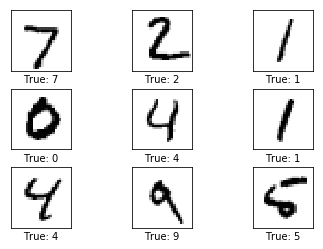

In [5]:
images = data.test.images[0:9]
y_true_cls = data.test.cls[0:9]

util.plot_images(images=images, img_shape=img_shape, cls_true=y_true_cls)

# Model

In [6]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [7]:
# Input image. The size is 28*28=784, which is img_size_flat
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
print(x)
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

Tensor("x:0", shape=(?, 784), dtype=float32)


In [8]:
# input layer.  Convert input to 28*28
x_image = tf.reshape(x, [-1, 28, 28, 1])
print(x_image)

Tensor("Reshape:0", shape=(?, 28, 28, 1), dtype=float32)


In [9]:
conv1 = tf.layers.conv2d(
    inputs=x_image,
    # number of filters/kernels. 1 result img per filter.
    filters=4, 
    kernel_size=[5, 5],
    # padding 'valid' will shrink the result img size. 'same' keeps img size.
    padding="same",
    activation=tf.nn.relu)
print(conv1)

# result of pooling depends on pool size, and strides
# result img size is roughly (input_size-pool_size+1)/strides
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
print(pool1)

Tensor("conv2d/Relu:0", shape=(?, 28, 28, 4), dtype=float32)
Tensor("max_pooling2d/MaxPool:0", shape=(?, 14, 14, 4), dtype=float32)


In [10]:
conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=8,
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.relu)
print(conv2)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
print(pool2)

Tensor("conv2d_2/Relu:0", shape=(?, 14, 14, 8), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 7, 7, 8), dtype=float32)


In [11]:
pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
dense = tf.layers.dense(inputs=pool2_flat, units=256, activation=tf.nn.relu)
dropout_train = tf.layers.dropout(
  inputs=dense, rate=0.4, training=True)
print(pool2_flat)
print(dense)
print(dropout_train)

Tensor("Reshape_1:0", shape=(?, 3136), dtype=float32)
Tensor("dense/Relu:0", shape=(?, 256), dtype=float32)
Tensor("dropout/dropout/mul:0", shape=(?, 256), dtype=float32)


In [12]:
fc1 = tf.layers.dense(inputs=dropout_train, units=128)
print(fc1)
# activation = tf.nn.softmax is not used. We use logits 
fc2 = tf.layers.dense(inputs=fc1, units=10, activation=None)
print(fc2)

Tensor("dense_2/BiasAdd:0", shape=(?, 128), dtype=float32)
Tensor("dense_3/BiasAdd:0", shape=(?, 10), dtype=float32)


In [13]:
y_pred = fc2
y_pred_cls = tf.argmax(y_pred, dimension=1)
print(y_pred)
print(y_pred_cls)

# 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    logits=fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Tensor("dense_3/BiasAdd:0", shape=(?, 10), dtype=float32)
Tensor("ArgMax_1:0", shape=(?,), dtype=int64)


In [14]:
# Launch the graph
training_iters = 10000
batch_size=8
display_step = 2

with tf.device('/gpu:0'):
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        step = 1
        # Keep training until reach max iterations
        while step * batch_size < training_iters:
            batch_x, batch_y = data.train.next_batch(batch_size)
            print(batch_x)
            
            # Run optimization op (backprop)
            sess.run(optimizer, feed_dict={x: batch_x, y_true: batch_y})
            if step % display_step == 0:
                # Calculate batch loss and accuracy
                loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                                  y_true: batch_y,
                                                                  keep_prob: 1.})
                print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
            step += 1
        print("Optimization Finished!")

        # Calculate accuracy for 256 mnist test images
        print("Testing Accuracy:", \
            sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
                                          y_true: mnist.test.labels[:256],
                                          keep_prob: 1.}))

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


KeyboardInterrupt: 